<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Machine-Learning-and-Deep-Learning-Projects/blob/main/sms%20classification/sms_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

**Instructions:**

Create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, we will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.




In [1]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575.0 MB 19 kB/s 
     |████████████████████████████████| 1.7 MB 35.5 MB/s 
     |████████████████████████████████| 5.8 MB 43.3 MB/s 
     |████████████████████████████████| 438 kB 56.8 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"

train_file_path = tf.keras.utils.get_file("train-data.tsv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("valid-data.tsv", TEST_DATA_URL)

118774/118774 [==============================] - 0s 0us/step


In [3]:
df_train = pd.read_csv(train_file_path, sep="\t", header=None)
df_train.head()

,0,1
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [4]:
df_test = pd.read_csv(test_file_path, sep="\t", header=None)
df_test.head()

,0,1
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [5]:
print(df_train.shape)
print(df_test.shape)

(4179, 2)
(1392, 2)


In [6]:
# Convert labels ham and spam to 0 and 1
df_train["spam"] = pd.get_dummies(df_train[0], drop_first=True)
df_train = df_train.drop(0, axis=1)

df_test["spam"] = pd.get_dummies(df_test[0], drop_first=True)
df_test = df_test.drop(0, axis=1)

In [7]:
df_train.head()

,1,spam
0,ahhhh...just woken up!had a bad dream about u ...,0
1,you can never do nothing,0
2,"now u sound like manky scouse boy steve,like! ...",0
3,mum say we wan to go then go... then she can s...,0
4,never y lei... i v lazy... got wat? dat day ü ...,0


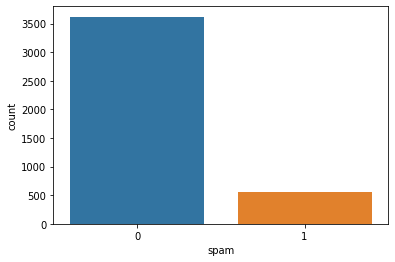

In [8]:
import seaborn as sns
sns.countplot(x="spam",data=df_train)

In [9]:
df_test.head()

,1,spam
0,i am in hospital da. . i will return home in e...,0
1,"not much, just some textin'. how bout you?",0
2,i probably won't eat at all today. i think i'm...,0
3,don‘t give a flying monkeys wot they think and...,0
4,who are you seeing?,0


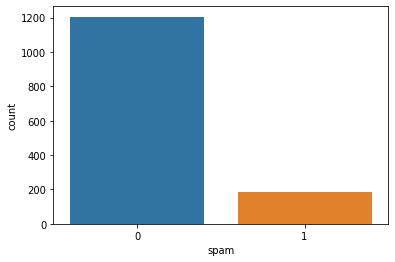

In [10]:
sns.countplot(x="spam",data=df_test)

In [11]:
train_data = (tf.data.Dataset.from_tensor_slices((tf.cast(df_train[1].values, tf.string),
                                                  tf.cast(df_train["spam"].values, tf.int32))
                                                ))

test_data = (tf.data.Dataset.from_tensor_slices((tf.cast(df_test[1].values, tf.string),
                                                 tf.cast(df_test["spam"].values, tf.int32))
                                               ))

In [12]:
!pip install -q tensorflow-hub
import tensorflow_hub as hub
print("Hub version: ", hub.__version__)

Hub version:  0.12.0


In [13]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.',
       b'you can never do nothing',
       b'now u sound like manky scouse boy steve,like! i is travelling on da bus home.wot has u inmind 4 recreation dis eve?',
       b'mum say we wan to go then go... then she can shun bian watch da glass exhibition...',
       b'never y lei... i v lazy... got wat? dat day \xc3\xbc send me da url cant work one...',
       b'in xam hall boy asked girl tell me the starting term for dis answer i can den manage on my own after lot of hesitation n lookin around silently she said the! intha ponnungale ipaditan;)',
       b"genius what's up. how your brother. pls send his number to my skype.",
       b'they finally came to fix the ceiling.',
       b'urgent! call 09066350750 from your landline. your complimentary 4* ibiza holiday or 10,000 cash await colle

In [14]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)>

In [15]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 6.5803975e-01, -2.6694477e+00,  2.1699309e+00,  1.1914589e+00,
        -4.5830355e+00, -2.6140189e+00, -3.3451486e+00,  1.0574487e+00,
         2.7708957e+00,  9.0441662e-01, -2.7067542e+00,  1.0917737e+00,
         2.1099505e+00,  8.0555040e-01, -2.8804941e+00,  7.6715600e-01,
         2.6439478e+00, -6.2924510e-01, -1.8367645e+00, -1.5989085e+00],
       [ 6.9591868e-01, -1.7398572e+00,  1.5667624e+00,  1.5939382e+00,
        -3.1426187e+00, -2.8005672e+00, -1.2499360e+00,  1.3363264e+00,
         9.0420026e-01,  9.5162886e-01, -7.7567214e-01, -3.9877254e-03,
         9.1853809e-01,  5.8934504e-01, -2.2077188e+00,  4.9703789e-01,
         2.5231953e+00, -2.0407477e-01, -6.8490952e-01, -1.0306396e+00],
       [ 5.3883386e-01, -7.3225409e-01,  1.1867530e+00,  5.3527482e-02,
        -1.1466477e+00, -4.2752609e-01, -1.6493666e+00,  6.5955973e-01,
         6.7386132e-01,  8.4187484e-01, -2.3974545e+00,  1.5436208e+00,
         4.95

In [16]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=test_data.batch(512),
                    verbose=1)

Epoch 1/20
9/9 [==============================] - 1s 38ms/step - loss: 0.5097 - accuracy: 0.8516 - val_loss: 0.4296 - val_accuracy: 0.8693
Epoch 2/20
9/9 [==============================] - 0s 15ms/step - loss: 0.4090 - accuracy: 0.8648 - val_loss: 0.3678 - val_accuracy: 0.8743
Epoch 3/20
9/9 [==============================] - 0s 15ms/step - loss: 0.3617 - accuracy: 0.8696 - val_loss: 0.3361 - val_accuracy: 0.8772
Epoch 4/20
9/9 [==============================] - 0s 15ms/step - loss: 0.3342 - accuracy: 0.8744 - val_loss: 0.3135 - val_accuracy: 0.8800
Epoch 5/20
9/9 [==============================] - 0s 16ms/step - loss: 0.3122 - accuracy: 0.8811 - val_loss: 0.2934 - val_accuracy: 0.8851
Epoch 6/20
9/9 [==============================] - 0s 14ms/step - loss: 0.2919 - accuracy: 0.8906 - val_loss: 0.2748 - val_accuracy: 0.8930
Epoch 7/20
9/9 [==============================] - 0s 16ms/step - loss: 0.2727 - accuracy: 0.8985 - val_loss: 0.2586 - val_accuracy: 0.9037
Epoch 8/20
9/9 [===========

In [19]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

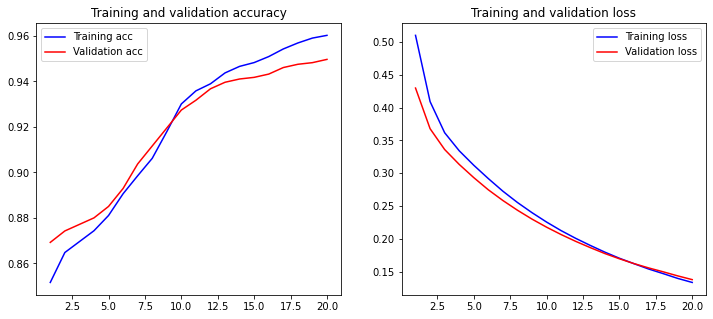

In [20]:
plot_history(history)

In [21]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print(f"{name}: {value}")

3/3 - 0s - loss: 0.1383 - accuracy: 0.9497 - 26ms/epoch - 9ms/step
loss: 0.13829481601715088
accuracy: 0.9497126340866089


In [22]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  pred_text = [pred_text]
  prediction = tf.cast(pred_text, tf.string)
  prediction = model.predict(prediction)[0]
  if prediction[0] > 0:
    prediction = [prediction[0], "spam"]
  else:
    prediction = [prediction[0], "ham"]

  return (prediction)

pred_text = "how are you doing today?"
# pred_text = "sale today! to stop texts call 98912460324"
# pred_text = "you have won £1000 cash! call to claim your prize."

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 160ms/step
[-5.25294, 'ham']


In [23]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 25ms/step
You passed the challenge. Great job!
